# **Tuned Model**

In this notebook we take information learned from our previous notebooks to tune our model to the best fit possible. The models in this notebook represent the best possible models from many iterations. The first model presented includes all feature columns, the second model presented has the features of work class and native country removed. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, f1_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import export_graphviz
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
train = pd.read_csv('./data/large_train_sample.csv')
test = pd.read_csv('./data/test_data.csv')

In [3]:
print(f'Train csv shape is {train.shape}')
print(f'Test csv shape is {test.shape}')

Train csv shape is (32561, 14)
Test csv shape is (16281, 13)


In [4]:
# We have imbalanced classes
train['wage'].value_counts(normalize=True)

 <=50K    0.75919
 >50K     0.24081
Name: wage, dtype: float64

In [5]:
#Credit to Chris

# Function that generates all the value counts for each column

def columns_values(dataframe):
    for n in dataframe.columns:                               # cycle through the columns in dataframe
        column = n  
        value_counts = (dataframe[column].value_counts())     # run value counts for each column
        unique_values = (dataframe[column].unique())          # run unique values for each column 
        len_counts = len(value_counts)                        # how many items are counted in value counts
        len_unique = len(unique_values)                       # how many items are counted in unique values
        if (len(value_counts)< 100):                          # ignore columns where counts over 100
                print(f"{column} has length of {len_unique}") # print how many unique values there are
                print(unique_values)                          # print unique values for column 
                print("="*30)                                  
                print(f"{column} has length of {len_counts}") # print how many values are counted
                print(value_counts)                           # print unique values counted
                print("="*60)

In [6]:
train_columns = columns_values(train)

age has length of 73
[39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87]
age has length of 73
36    898
31    888
34    886
23    877
35    876
33    875
28    867
30    861
37    858
25    841
27    835
32    828
38    827
39    816
29    813
41    808
24    798
40    794
26    785
42    780
43    770
22    765
20    753
46    737
45    734
44    724
21    720
19    712
47    708
50    602
51    595
49    577
18    550
48    543
52    478
53    464
55    419
54    415
17    395
58    366
56    366
57    358
59    355
60    312
61    300
62    258
63    230
64    208
65    178
67    151
66    150
68    120
69    108
70     89
71     72
72     67
73     64
74     51
76     46
75     45
90     43
77     29
78     23
80     22
79     22
81     20
82     12
84     10
83      6
85      3
88      3
87      1
86      1
Name

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  wage            32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [8]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,<=50K


In [9]:
# Binarizing Wage Column

train['wage'] = pd.get_dummies(train['wage'], drop_first=True)

In [10]:
# Baseline Accuracy Score

train['wage'].value_counts(normalize=True)

0    0.75919
1    0.24081
Name: wage, dtype: float64

In [11]:
# Descriptive Statistics of numeric data prior to handling outliers

train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,wage
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456,0.240810
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [12]:
# Shape of data prior to handling outliers
print(f'Train csv shape is {train.shape}')
print(f'Test csv shape is {test.shape}')

Train csv shape is (32561, 14)
Test csv shape is (16281, 13)


In [13]:
train_col = ['age',
            'fnlwgt',
            'education-num',
            'capital-gain',
            'capital-loss',
            'hours-per-week',
            'wage'    
            ]

In [14]:
for col in train[train_col]:
    outlier = abs(train[col].std() * 3) + abs(train[col].mean())
    train.drop(train[train[col] > outlier].index, inplace=True)

In [15]:
# Descriptive Statistics of numeric data after handling outliers

train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,wage
count,30108.000000,30108.000000,30108.000000,30108.000000,30108.000000,30108.000000,30108.000000
mean,38.226485,185488.998738,10.022486,567.151156,1.212037,39.784011,0.221503
std,13.424234,94667.976151,2.538230,2326.937114,32.648206,11.294637,0.415265
min,17.000000,12285.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,27.000000,117606.000000,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,177817.000000,10.000000,0.000000,0.000000,40.000000,0.000000
75%,47.000000,234723.500000,12.000000,0.000000,0.000000,45.000000,0.000000
max,79.000000,506436.000000,16.000000,22040.000000,1258.000000,77.000000,1.000000


In [16]:
# Shape of data after handling outliers
print(f'Train csv shape is {train.shape}')

Train csv shape is (30108, 14)


In [17]:
# # Not using Work Class and Native Country
# def dummies(train, test):
# #     train['wage'] = pd.get_dummies(train['wage'], drop_first=True)
#     dums_train = pd.get_dummies(train[['education', 'marital-status', 'occupation', 'relationship', 'sex']], drop_first=True)
#     dums_test = pd.get_dummies(test[['education', 'marital-status', 'occupation', 'relationship', 'sex']], drop_first=True)
#     final_train = train.join(dums_train)
#     final_test = test.join(dums_test)
#     final_train.drop(columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country'], inplace=True)
#     final_test.drop(columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country'], inplace=True)
#     return final_train, final_test
    

In [18]:
# Baseline after removing outliers

train['wage'].value_counts(normalize=True)

0    0.778497
1    0.221503
Name: wage, dtype: float64

In [19]:
# train_df, test_df = dummies(train, test)

In [20]:
# train_df.shape

In [21]:
# test_df.shape

In [22]:
# set(train_df.columns) - set(test_df.columns)

In [23]:
# set(test_df.columns) - set(train_df.columns)

In [24]:
# train_df = train_df.drop(columns='native-country_ Holand-Netherlands')

# Model with all Parameters

In [25]:
# function that will dummify the categorical columns in each set, and combine them with the original dataframes
def dummies_all(train, test):
    train['wage'] = pd.get_dummies(train['wage'], drop_first=True)
    dums_train = pd.get_dummies(train[['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']], drop_first=True)
    dums_test = pd.get_dummies(test[['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']], drop_first=True)
    final_train = train.join(dums_train)
    final_test = test.join(dums_test)
    final_train.drop(columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country'], inplace=True)
    final_test.drop(columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country'], inplace=True)
    return final_train, final_test
    

In [26]:
train_df_all, test_df_all = dummies_all(train, test)

In [27]:
# Shape of data after dummifying features
print(f'Train_df_all dataframe shape is {train_df_all.shape}')
print(f'Test_df_all dataframe shape is {test_df_all.shape}')


Train_df_all dataframe shape is (30108, 96)
Test_df_all dataframe shape is (16281, 95)


In [28]:
# Check for differences

set(train_df_all.columns) - set(test_df_all.columns)

{'wage'}

In [29]:
# Check for differences

set(test_df_all.columns) - set(train_df_all.columns)

set()

In [30]:
X_all = train_df_all.drop(columns=['wage'])
y_all = train_df_all['wage']

In [31]:
print(X_all.shape)
print(y_all.shape)

(30108, 95)
(30108,)


In [32]:
# Instantiate Standard Scaler

sc = StandardScaler()

# Create train/test split on all features training dataframe

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, stratify=y_all, random_state=42)

# Fiting to the training data, and transforming training and testing data

X_train_sc_all = sc.fit_transform(X_train_all)
X_test_sc_all = sc.transform(X_test_all)

In [33]:
#Instantiate Random Forest

rf = RandomForestClassifier()

# Setting our parameters for the random forest to be used in the gridsearch, 
# the below parameters represent the best after many iterations

rf_params_all = {
    'max_depth' : [9],
    'min_samples_leaf' : [3],
    'min_samples_split' : [6],
    'n_estimators' : [37],
    'ccp_alpha' : [1, .1, .01, .001, .0001],
#     'gamma' : .
    'verbose' : [1]
}

# Instantiate the Gridsearch 

gs_all = GridSearchCV(rf, param_grid=rf_params_all, cv=5, n_jobs=-1)

# fit the gridsearch to the all features training data 

gs_all.fit(X_train_sc_all, y_train_all);

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    0.3s finished


In [34]:
print(f'Tuned Model All Features Train Score: {round(gs_all.score(X_train_sc_all, y_train_all)*100, 2)}%')
print(f'Tuned Model All Features Test Score: {round(gs_all.score(X_test_sc_all, y_test_all)*100, 2)}%')
print(f'Tuned Modeal All Features Gridsearch Best Parameters are {gs_all.best_params_}')

Tuned Model All Features Train Score: 85.6%
Tuned Model All Features Test Score: 85.63%
Tuned Modeal All Features Gridsearch Best Parameters are {'ccp_alpha': 0.0001, 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 37, 'verbose': 1}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    0.0s finished


# Model with workclass and native country removed

In [35]:
# Has all the features to dummify except for work class and native country

def dummies(train, test):
    train['wage'] = pd.get_dummies(train['wage'], drop_first=True)
    dums_train = pd.get_dummies(train[['education', 'marital-status', 'occupation', 'relationship', 'sex']], drop_first=True)
    dums_test = pd.get_dummies(test[['education', 'marital-status', 'occupation', 'relationship', 'sex']], drop_first=True)
    final_train = train.join(dums_train)
    final_test = test.join(dums_test)
    final_train.drop(columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country'], inplace=True)
    final_test.drop(columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country'], inplace=True)
    return final_train, final_test
    

In [36]:
train_df, test_df = dummies(train, test)

In [37]:
train_df.shape

(30108, 48)

In [38]:
test_df.shape

(16281, 47)

In [39]:
# Check for differences

set(train_df.columns) - set(test_df.columns)

{'wage'}

In [40]:
# Check for differences

set(test_df.columns) - set(train_df.columns)

set()

In [41]:
X = train_df.drop(columns=['wage'])
y = train_df['wage']

In [42]:
print(X.shape)
print(y.shape)

(30108, 47)
(30108,)


In [43]:
# Create train/test split on all features training dataframe

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# fit the gridsearch to the all features training data 

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [44]:
# Setting our parameters for the random forest to be used in the gridsearch, 
# the below parameters represent the best after many iterations

rf_params = {
    'max_depth' : [9],
    'min_samples_leaf' : [3],
    'min_samples_split' : [6],
    'n_estimators' : [37],
    'ccp_alpha' : [1, .1, .01, .001, .0001],
#     'gamma' : .
    'verbose' : [1]
}

# Instantiate the Gridsearch 

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)

# fit the gridsearch to the all features training data 

gs.fit(X_train_sc, y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    0.3s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [1, 0.1, 0.01, 0.001, 0.0001],
                         'max_depth': [9], 'min_samples_leaf': [3],
                         'min_samples_split': [6], 'n_estimators': [37],
                         'verbose': [1]})

In [45]:
print(f'Tuned Model Limited Features Train Score: {round(gs.score(X_train_sc, y_train)*100, 2)}%')
print(f'Tuned Model Limited Features Test Score: {round(gs.score(X_test_sc, y_test)*100, 2)}%')
print(f'Tuned Modeal All Features Gridsearch Best Parameters are {gs.best_params_}')

Tuned Model Limited Features Train Score: 85.89%
Tuned Model Limited Features Test Score: 85.72%
Tuned Modeal All Features Gridsearch Best Parameters are {'ccp_alpha': 0.0001, 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 37, 'verbose': 1}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    0.0s finished


In [46]:
# We found that workclass and native_country has no impact on the Score

In [47]:
# Now we will get the best parameters on this new model with gridserach
# After many attempts, these parameters gave the best fit
rf_params = {
    'max_depth' : [7, 9, 11, 14],
    'min_samples_leaf' : [2, 3, 4, 5],
    'min_samples_split' : [4, 6, 8, 10],
    'n_estimators' : [34, 37, 40],
    'ccp_alpha' : [1, .1, .01, .001, .0001],
#     'gamma' : .
    'verbose' : [1]
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)
gs.fit(X_train_sc, y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    0.4s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [1, 0.1, 0.01, 0.001, 0.0001],
                         'max_depth': [7, 9, 11, 14],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [4, 6, 8, 10],
                         'n_estimators': [34, 37, 40], 'verbose': [1]})

In [48]:
gs.best_params_

{'ccp_alpha': 0.0001,
 'max_depth': 14,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 34,
 'verbose': 1}

In [49]:
print(f'Tuned Model Limited Features Train Score: {round(gs.score(X_train_sc, y_train)*100, 2)}%')
print(f'Tuned Model Limited Features Test Score: {round(gs.score(X_test_sc, y_test)*100, 2)}%')
print(f'Tuned Model Limited Features Gridsearch Best Parameters are {gs.best_params_}')

Tuned Model Limited Features Train Score: 86.81%
Tuned Model Limited Features Test Score: 85.96%
Tuned Model Limited Features Gridsearch Best Parameters are {'ccp_alpha': 0.0001, 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 34, 'verbose': 1}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    0.0s finished


# Visualizations

In [50]:
# Get predictions for Simple Logisitic Regression

preds = gs.predict(X_test_sc)

# Confusion matrix values

TN, FP, FN, TP = confusion_matrix(y_test, preds).ravel()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    0.0s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    0.0s finished


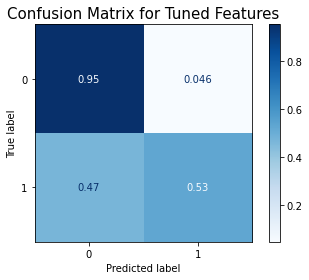

In [51]:
plot_confusion_matrix(gs, X_test_sc, y_test, cmap='Blues', normalize='true');
plt.title('Confusion Matrix for Tuned Features', size = 15);

In [52]:
# Accuracy:  # What percentage of observation did I correctly predict?

print(f"The Accuracy score is: {round((TP + TN) / (TP + TN + FP + FN), 3) * 100}%")
# Misclassification: # What percentage of observation did I incorrectly predict?

print(f"The Missclassification rate is: {round((FP + FN) / (TP + TN + FP + FN), 4) * 100}%")
# Sensitivity:  # Among Positives, how many did I get correctly? Same as recall

print(f"The Sensitivity is: {round(TP / (TP + FN), 3) * 100}%")

# Specificity:  # Among Negatives, how many did I get correctly?
print(f"The Specificity is: {round(TN / (TN + FP), 3) * 100}%")

# Precision: # Among Positives, how many did i Predict correct

print(f"The Precision is {round(TP / (TP + FP), 4) * 100}%")

The Accuracy score is: 86.0%
The Missclassification rate is: 14.04%
The Sensitivity is: 52.800000000000004%
The Specificity is: 95.39999999999999%
The Precision is 76.48%


# Predictions

In [53]:
## UNCOMMENT THE BELOW LINES TO MAKE NEW CSV FOR PREDICTIONS

In [54]:
## Scale the testing data
# s_test = StandardScaler()
# scaled_test = s_test.fit_transform(test_df)

In [55]:
# y_preds = gs.predict(scaled_test)

In [56]:
# wage_predictions = pd.DataFrame({'wage': y_preds})

In [57]:
# wage_predictions.to_csv('./data/wage_predictions.csv', index=False)

In [58]:
# wage_predictions

In [59]:
# test.shape